# Data Augmentation v3
This notebook performs data augmentation on the dataset by creating an augmented copy of each image in the original dataset. Original dataset images are taken from the ```dataset``` folder, while original and augmented images are saved to the ```dataset-augmented-v3``` folder.

This second version generates more data than the ```dataset-augmented``` notebook and folder. Whereas ```dataset-augmented``` generates 2x the original dataset, this notebook generates 4x the original dataset.

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import Dataset, DataLoader

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Folders for input (original images) and output (original + augmented images)
in_folder = r"dataset/"
out_folder = r"dataset-augmented-v2/"

In [3]:
# Set seed for PyTorch random number generation to create reproducible results
torch.manual_seed(5)

In [4]:
# Convert PIL Image to tensor
to_tensor = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

translation_matrix = torch.tensor([[0, 1, 0], [0, 0, 1], [1, 0, 0]])

# Transformations to apply to inputs, where one is randomly chosen and applied per image
augmentations = transforms.RandomChoice([
    # Rotate by a random amount within -3 to -1 degrees
    transforms.RandomRotation(degrees=(-3, -1), fill=255), 
    
    # Rotate by a random amount within 1 to 3 degrees
    transforms.RandomRotation(degrees=(1, 3), fill=255), 
    
    # Translate horizontally by a random percentage between -15% and 15% and
    # vertically by a random percentage between -15% and 15%
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), fill=255), 
    
    # Horizontally flips the image
    transforms.RandomHorizontalFlip(p=1)
])

In [5]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Augment Data

In [6]:
# Image dataset
class AugmentedDataset(Dataset):
    def __init__(self, img_dir, to_tensor, augment):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.to_tensor = to_tensor
        self.augment = augmentations

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Augment image
        image = Image.open(img_path).convert("RGB")
        image = self.to_tensor(image)
        image = self.augment(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label, filename

In [7]:
# Dataset and dataloader for images
data = AugmentedDataset(img_dir=in_folder, to_tensor=to_tensor, augment=augmentations)
loader = DataLoader(data, batch_size=10, shuffle=True)

### Show Sample of Augmented Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Classes: 1 0 1 1 0 1 0 0 0 0
Original files:
0718-1-A.tif
0083-0-P.tif
0408-1-A.tif
0422-1-A.tif
0375-0-P.tif
0994-1-A.tif
0594-0-A.tif
1031-0-P.tif
0091-0-P.tif
0935-0-A.tif


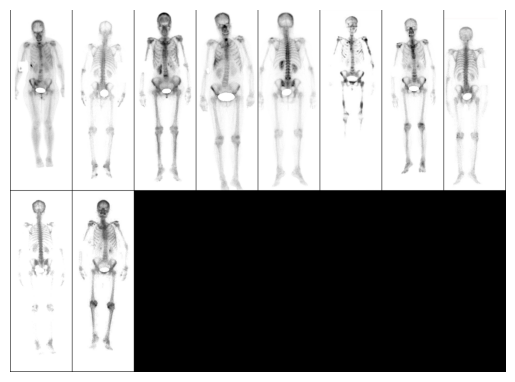

In [8]:
# Show random augmented images and their ground truth classes
dataiter = iter(loader)
images, labels, filenames = next(dataiter)

plt.axis('off')
plt.imshow(make_grid(images).permute(1,2,0))
print("Classes: " + ' '.join(f'{labels[j]}' for j in range(len(labels))))
print("Original files:\n" + '\n'.join(f'{filenames[j]}' for j in range(len(filenames))))

### Save Augmented Images to Output Folder

In [9]:
# Copy original images to output folder
for filename in os.listdir(in_folder):
    in_file = os.path.join(in_folder, filename)
    shutil.copy(in_file, out_folder)

In [10]:
# Get index of last original image
last_filename = os.listdir(in_folder)[-1]
img_index = int(last_filename[0:4])

In [11]:
# Delete all previous copies of augmented images in folder (if any)
for filename in os.listdir(out_folder):
    if (int(filename[0:4]) > img_index):
        os.remove(os.path.join(out_folder, filename))

In [12]:
for batch_index, batch_data in enumerate(loader):
    # Get the images, labels, and filenames in the current batch
    images, labels, orig_filenames = batch_data
    
    # Iterate over each image in the original dataset
    for i in range(len(images)):
        
        # Create 7 augmented copies per original image in the dataset
        for j in range(7):
            
            # Create filename for augmented image
            img_index += 1
            new_filename = str(img_index) + orig_filenames[i][4:]
            img_path = out_folder + "/" + new_filename

            # Save augmented image
            save_image(images[i], img_path)
            print(f"Saved augmented copy of {orig_filenames[i]} as {new_filename} in {out_folder}")

Saved augmented copy of 0331-1-A.tif as 1226-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0331-1-A.tif as 1227-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0331-1-A.tif as 1228-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0331-1-A.tif as 1229-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0331-1-A.tif as 1230-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0331-1-A.tif as 1231-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0331-1-A.tif as 1232-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0188-1-A.tif as 1233-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0188-1-A.tif as 1234-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0188-1-A.tif as 1235-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0188-1-A.tif as 1236-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0188-1-A.tif as 1237-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0188-1-A.tif as 1238-1-A.tif in dataset-

Saved augmented copy of 0042-0-A.tif as 1359-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0042-0-A.tif as 1360-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0042-0-A.tif as 1361-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0042-0-A.tif as 1362-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0042-0-A.tif as 1363-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0042-0-A.tif as 1364-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0042-0-A.tif as 1365-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0910-0-A.tif as 1366-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0910-0-A.tif as 1367-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0910-0-A.tif as 1368-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0910-0-A.tif as 1369-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0910-0-A.tif as 1370-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0910-0-A.tif as 1371-0-A.tif in dataset-

Saved augmented copy of 0619-0-P.tif as 1467-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0619-0-P.tif as 1468-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0619-0-P.tif as 1469-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0619-0-P.tif as 1470-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1471-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1472-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1473-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1474-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1475-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1476-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0392-0-A.tif as 1477-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0078-0-A.tif as 1478-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0078-0-A.tif as 1479-0-A.tif in dataset-

Saved augmented copy of 0285-1-P.tif as 1576-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0285-1-P.tif as 1577-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0285-1-P.tif as 1578-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0285-1-P.tif as 1579-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0285-1-P.tif as 1580-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0285-1-P.tif as 1581-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0285-1-P.tif as 1582-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0241-1-P.tif as 1583-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0241-1-P.tif as 1584-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0241-1-P.tif as 1585-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0241-1-P.tif as 1586-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0241-1-P.tif as 1587-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0241-1-P.tif as 1588-1-P.tif in dataset-

Saved augmented copy of 1164-0-P.tif as 1700-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1164-0-P.tif as 1701-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1702-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1703-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1704-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1705-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1706-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1707-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0559-0-P.tif as 1708-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0678-0-A.tif as 1709-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0678-0-A.tif as 1710-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0678-0-A.tif as 1711-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0678-0-A.tif as 1712-0-A.tif in dataset-

Saved augmented copy of 0792-0-A.tif as 1815-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0792-0-A.tif as 1816-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0792-0-A.tif as 1817-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0792-0-A.tif as 1818-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0792-0-A.tif as 1819-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0792-0-A.tif as 1820-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1821-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1822-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1823-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1824-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1825-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1826-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0803-0-A.tif as 1827-0-A.tif in dataset-

Saved augmented copy of 1024-0-P.tif as 1922-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1024-0-P.tif as 1923-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1024-0-P.tif as 1924-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1024-0-P.tif as 1925-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1926-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1927-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1928-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1929-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1930-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1931-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0693-0-P.tif as 1932-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0141-0-P.tif as 1933-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0141-0-P.tif as 1934-0-P.tif in dataset-

Saved augmented copy of 0251-1-P.tif as 2030-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2031-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2032-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2033-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2034-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2035-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2036-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1213-1-P.tif as 2037-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0462-0-P.tif as 2038-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0462-0-P.tif as 2039-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0462-0-P.tif as 2040-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0462-0-P.tif as 2041-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0462-0-P.tif as 2042-0-P.tif in dataset-

Saved augmented copy of 0103-0-P.tif as 2136-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0103-0-P.tif as 2137-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0103-0-P.tif as 2138-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0103-0-P.tif as 2139-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0103-0-P.tif as 2140-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0103-0-P.tif as 2141-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0103-0-P.tif as 2142-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0603-0-P.tif as 2143-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0603-0-P.tif as 2144-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0603-0-P.tif as 2145-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0603-0-P.tif as 2146-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0603-0-P.tif as 2147-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0603-0-P.tif as 2148-0-P.tif in dataset-

Saved augmented copy of 1058-0-P.tif as 2254-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2255-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2256-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2257-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2258-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2259-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2260-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1216-1-P.tif as 2261-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0136-0-A.tif as 2262-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0136-0-A.tif as 2263-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0136-0-A.tif as 2264-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0136-0-A.tif as 2265-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0136-0-A.tif as 2266-0-A.tif in dataset-

Saved augmented copy of 1167-0-P.tif as 2374-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1167-0-P.tif as 2375-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1167-0-P.tif as 2376-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1167-0-P.tif as 2377-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1167-0-P.tif as 2378-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1167-0-P.tif as 2379-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1167-0-P.tif as 2380-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0576-0-A.tif as 2381-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0576-0-A.tif as 2382-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0576-0-A.tif as 2383-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0576-0-A.tif as 2384-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0576-0-A.tif as 2385-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0576-0-A.tif as 2386-0-A.tif in dataset-

Saved augmented copy of 1183-1-P.tif as 2486-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1183-1-P.tif as 2487-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1183-1-P.tif as 2488-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1183-1-P.tif as 2489-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1183-1-P.tif as 2490-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1183-1-P.tif as 2491-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1183-1-P.tif as 2492-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0926-0-A.tif as 2493-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0926-0-A.tif as 2494-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0926-0-A.tif as 2495-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0926-0-A.tif as 2496-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0926-0-A.tif as 2497-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0926-0-A.tif as 2498-0-A.tif in dataset-

Saved augmented copy of 0293-1-P.tif as 2609-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0293-1-P.tif as 2610-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0293-1-P.tif as 2611-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2612-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2613-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2614-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2615-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2616-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2617-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1067-0-P.tif as 2618-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1204-1-P.tif as 2619-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1204-1-P.tif as 2620-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1204-1-P.tif as 2621-1-P.tif in dataset-

Saved augmented copy of 0940-0-A.tif as 2718-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0940-0-A.tif as 2719-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0940-0-A.tif as 2720-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0940-0-A.tif as 2721-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0940-0-A.tif as 2722-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0940-0-A.tif as 2723-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2724-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2725-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2726-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2727-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2728-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2729-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0781-1-A.tif as 2730-1-A.tif in dataset-

Saved augmented copy of 0524-1-A.tif as 2830-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0524-1-A.tif as 2831-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0524-1-A.tif as 2832-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0524-1-A.tif as 2833-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0524-1-A.tif as 2834-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0524-1-A.tif as 2835-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2836-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2837-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2838-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2839-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2840-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2841-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0807-0-A.tif as 2842-0-A.tif in dataset-

Saved augmented copy of 0296-0-P.tif as 2938-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0296-0-P.tif as 2939-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0296-0-P.tif as 2940-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2941-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2942-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2943-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2944-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2945-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2946-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1026-0-P.tif as 2947-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0960-1-A.tif as 2948-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0960-1-A.tif as 2949-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0960-1-A.tif as 2950-1-A.tif in dataset-

Saved augmented copy of 0956-0-A.tif as 3046-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0956-0-A.tif as 3047-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0956-0-A.tif as 3048-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0956-0-A.tif as 3049-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0956-0-A.tif as 3050-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0956-0-A.tif as 3051-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0956-0-A.tif as 3052-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0571-0-P.tif as 3053-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0571-0-P.tif as 3054-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0571-0-P.tif as 3055-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0571-0-P.tif as 3056-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0571-0-P.tif as 3057-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0571-0-P.tif as 3058-0-P.tif in dataset-

Saved augmented copy of 0700-1-A.tif as 3157-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3158-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3159-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3160-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3161-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3162-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3163-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0071-0-P.tif as 3164-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1066-0-P.tif as 3165-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1066-0-P.tif as 3166-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1066-0-P.tif as 3167-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1066-0-P.tif as 3168-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1066-0-P.tif as 3169-0-P.tif in dataset-

Saved augmented copy of 1002-1-A.tif as 3265-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 1002-1-A.tif as 3266-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 1002-1-A.tif as 3267-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 1002-1-A.tif as 3268-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 1002-1-A.tif as 3269-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3270-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3271-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3272-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3273-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3274-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3275-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0522-0-A.tif as 3276-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0286-1-A.tif as 3277-1-A.tif in dataset-

Saved augmented copy of 0474-1-A.tif as 3378-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0474-1-A.tif as 3379-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0474-1-A.tif as 3380-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0474-1-A.tif as 3381-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3382-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3383-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3384-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3385-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3386-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3387-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0175-1-P.tif as 3388-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0248-1-A.tif as 3389-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0248-1-A.tif as 3390-1-A.tif in dataset-

Saved augmented copy of 0948-0-A.tif as 3495-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0948-0-A.tif as 3496-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0948-0-A.tif as 3497-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0948-0-A.tif as 3498-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0948-0-A.tif as 3499-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0948-0-A.tif as 3500-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3501-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3502-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3503-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3504-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3505-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3506-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0008-0-A.tif as 3507-0-A.tif in dataset-

Saved augmented copy of 1197-1-P.tif as 3604-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1197-1-P.tif as 3605-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3606-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3607-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3608-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3609-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3610-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3611-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0734-0-A.tif as 3612-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 1089-0-P.tif as 3613-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1089-0-P.tif as 3614-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1089-0-P.tif as 3615-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1089-0-P.tif as 3616-0-P.tif in dataset-

Saved augmented copy of 0102-0-A.tif as 3723-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0102-0-A.tif as 3724-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3725-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3726-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3727-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3728-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3729-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3730-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0342-1-A.tif as 3731-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0822-0-A.tif as 3732-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0822-0-A.tif as 3733-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0822-0-A.tif as 3734-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0822-0-A.tif as 3735-0-A.tif in dataset-

Saved augmented copy of 1221-1-P.tif as 3836-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3837-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3838-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3839-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3840-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3841-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3842-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1092-0-P.tif as 3843-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0992-1-A.tif as 3844-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0992-1-A.tif as 3845-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0992-1-A.tif as 3846-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0992-1-A.tif as 3847-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0992-1-A.tif as 3848-1-A.tif in dataset-

Saved augmented copy of 1150-0-P.tif as 3950-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1150-0-P.tif as 3951-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1150-0-P.tif as 3952-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1150-0-P.tif as 3953-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1150-0-P.tif as 3954-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1150-0-P.tif as 3955-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3956-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3957-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3958-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3959-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3960-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3961-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0336-0-A.tif as 3962-0-A.tif in dataset-

Saved augmented copy of 0823-0-A.tif as 4058-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0823-0-A.tif as 4059-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0823-0-A.tif as 4060-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4061-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4062-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4063-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4064-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4065-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4066-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0801-0-A.tif as 4067-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0859-0-A.tif as 4068-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0859-0-A.tif as 4069-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0859-0-A.tif as 4070-0-A.tif in dataset-

Saved augmented copy of 1095-0-P.tif as 4166-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1095-0-P.tif as 4167-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1095-0-P.tif as 4168-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1095-0-P.tif as 4169-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1095-0-P.tif as 4170-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1095-0-P.tif as 4171-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1095-0-P.tif as 4172-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0780-0-P.tif as 4173-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0780-0-P.tif as 4174-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0780-0-P.tif as 4175-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0780-0-P.tif as 4176-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0780-0-P.tif as 4177-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0780-0-P.tif as 4178-0-P.tif in dataset-

Saved augmented copy of 0484-0-A.tif as 4277-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4278-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4279-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4280-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4281-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4282-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4283-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0472-0-A.tif as 4284-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0308-1-A.tif as 4285-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0308-1-A.tif as 4286-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0308-1-A.tif as 4287-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0308-1-A.tif as 4288-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0308-1-A.tif as 4289-1-A.tif in dataset-

Saved augmented copy of 1220-1-P.tif as 4387-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1220-1-P.tif as 4388-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1220-1-P.tif as 4389-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4390-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4391-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4392-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4393-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4394-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4395-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0767-1-P.tif as 4396-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1081-0-P.tif as 4397-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1081-0-P.tif as 4398-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1081-0-P.tif as 4399-0-P.tif in dataset-

Saved augmented copy of 0784-0-A.tif as 4500-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0784-0-A.tif as 4501-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4502-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4503-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4504-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4505-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4506-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4507-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0448-0-P.tif as 4508-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0350-1-A.tif as 4509-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0350-1-A.tif as 4510-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0350-1-A.tif as 4511-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0350-1-A.tif as 4512-1-A.tif in dataset-

Saved augmented copy of 0249-1-P.tif as 4617-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0249-1-P.tif as 4618-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0249-1-P.tif as 4619-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0249-1-P.tif as 4620-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4621-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4622-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4623-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4624-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4625-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4626-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1044-0-P.tif as 4627-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0818-0-A.tif as 4628-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0818-0-A.tif as 4629-0-A.tif in dataset-

Saved augmented copy of 0233-0-P.tif as 4723-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0233-0-P.tif as 4724-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0233-0-P.tif as 4725-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4726-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4727-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4728-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4729-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4730-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4731-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0047-1-P.tif as 4732-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0348-1-A.tif as 4733-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0348-1-A.tif as 4734-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0348-1-A.tif as 4735-1-A.tif in dataset-

Saved augmented copy of 0061-1-P.tif as 4829-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0061-1-P.tif as 4830-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4831-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4832-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4833-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4834-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4835-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4836-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1111-0-P.tif as 4837-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0999-1-A.tif as 4838-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0999-1-A.tif as 4839-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0999-1-A.tif as 4840-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0999-1-A.tif as 4841-1-A.tif in dataset-

Saved augmented copy of 0961-1-A.tif as 4936-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0961-1-A.tif as 4937-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0961-1-A.tif as 4938-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0961-1-A.tif as 4939-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0961-1-A.tif as 4940-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0961-1-A.tif as 4941-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0961-1-A.tif as 4942-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0870-0-A.tif as 4943-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0870-0-A.tif as 4944-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0870-0-A.tif as 4945-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0870-0-A.tif as 4946-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0870-0-A.tif as 4947-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0870-0-A.tif as 4948-0-A.tif in dataset-

Saved augmented copy of 0846-0-A.tif as 5047-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5048-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5049-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5050-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5051-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5052-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5053-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0552-0-A.tif as 5054-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 1016-0-P.tif as 5055-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1016-0-P.tif as 5056-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1016-0-P.tif as 5057-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1016-0-P.tif as 5058-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1016-0-P.tif as 5059-0-P.tif in dataset-

Saved augmented copy of 0941-0-A.tif as 5156-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0941-0-A.tif as 5157-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0941-0-A.tif as 5158-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0941-0-A.tif as 5159-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5160-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5161-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5162-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5163-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5164-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5165-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0662-0-A.tif as 5166-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0659-0-P.tif as 5167-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0659-0-P.tif as 5168-0-P.tif in dataset-

Saved augmented copy of 0340-1-A.tif as 5275-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0340-1-A.tif as 5276-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0340-1-A.tif as 5277-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0340-1-A.tif as 5278-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5279-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5280-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5281-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5282-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5283-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5284-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0021-1-P.tif as 5285-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0187-1-P.tif as 5286-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0187-1-P.tif as 5287-1-P.tif in dataset-

Saved augmented copy of 0045-0-P.tif as 5389-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0045-0-P.tif as 5390-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5391-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5392-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5393-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5394-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5395-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5396-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0963-1-A.tif as 5397-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0200-0-A.tif as 5398-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0200-0-A.tif as 5399-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0200-0-A.tif as 5400-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0200-0-A.tif as 5401-0-A.tif in dataset-

Saved augmented copy of 0649-1-P.tif as 5496-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0649-1-P.tif as 5497-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0649-1-P.tif as 5498-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0649-1-P.tif as 5499-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0649-1-P.tif as 5500-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0649-1-P.tif as 5501-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0649-1-P.tif as 5502-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0973-1-A.tif as 5503-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0973-1-A.tif as 5504-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0973-1-A.tif as 5505-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0973-1-A.tif as 5506-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0973-1-A.tif as 5507-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0973-1-A.tif as 5508-1-A.tif in dataset-

Saved augmented copy of 0069-1-P.tif as 5628-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5629-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5630-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5631-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5632-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5633-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5634-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0670-0-A.tif as 5635-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0147-0-P.tif as 5636-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0147-0-P.tif as 5637-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0147-0-P.tif as 5638-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0147-0-P.tif as 5639-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0147-0-P.tif as 5640-0-P.tif in dataset-

Saved augmented copy of 0167-0-P.tif as 5740-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5741-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5742-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5743-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5744-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5745-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5746-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0111-0-P.tif as 5747-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1186-1-P.tif as 5748-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1186-1-P.tif as 5749-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1186-1-P.tif as 5750-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1186-1-P.tif as 5751-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1186-1-P.tif as 5752-1-P.tif in dataset-

Saved augmented copy of 0984-1-A.tif as 5846-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0984-1-A.tif as 5847-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0984-1-A.tif as 5848-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0984-1-A.tif as 5849-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0984-1-A.tif as 5850-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0984-1-A.tif as 5851-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0984-1-A.tif as 5852-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0328-1-A.tif as 5853-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0328-1-A.tif as 5854-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0328-1-A.tif as 5855-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0328-1-A.tif as 5856-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0328-1-A.tif as 5857-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0328-1-A.tif as 5858-1-A.tif in dataset-

Saved augmented copy of 0717-1-P.tif as 5977-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0717-1-P.tif as 5978-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5979-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5980-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5981-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5982-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5983-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5984-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0933-0-A.tif as 5985-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0431-0-P.tif as 5986-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0431-0-P.tif as 5987-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0431-0-P.tif as 5988-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0431-0-P.tif as 5989-0-P.tif in dataset-

Saved augmented copy of 1208-1-P.tif as 6085-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1208-1-P.tif as 6086-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1208-1-P.tif as 6087-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1208-1-P.tif as 6088-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1208-1-P.tif as 6089-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1208-1-P.tif as 6090-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6091-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6092-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6093-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6094-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6095-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6096-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0066-0-A.tif as 6097-0-A.tif in dataset-

Saved augmented copy of 0730-0-P.tif as 6196-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0730-0-P.tif as 6197-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0730-0-P.tif as 6198-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0730-0-P.tif as 6199-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0730-0-P.tif as 6200-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0730-0-P.tif as 6201-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0730-0-P.tif as 6202-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0289-1-P.tif as 6203-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0289-1-P.tif as 6204-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0289-1-P.tif as 6205-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0289-1-P.tif as 6206-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0289-1-P.tif as 6207-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0289-1-P.tif as 6208-1-P.tif in dataset-

Saved augmented copy of 0595-0-P.tif as 6310-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0595-0-P.tif as 6311-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0595-0-P.tif as 6312-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0595-0-P.tif as 6313-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0595-0-P.tif as 6314-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6315-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6316-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6317-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6318-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6319-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6320-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0325-0-P.tif as 6321-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1048-0-P.tif as 6322-0-P.tif in dataset-

Saved augmented copy of 0628-1-A.tif as 6433-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6434-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6435-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6436-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6437-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6438-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6439-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0123-0-P.tif as 6440-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0108-0-A.tif as 6441-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0108-0-A.tif as 6442-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0108-0-A.tif as 6443-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0108-0-A.tif as 6444-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0108-0-A.tif as 6445-0-A.tif in dataset-

Saved augmented copy of 0723-0-P.tif as 6542-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0723-0-P.tif as 6543-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0723-0-P.tif as 6544-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0723-0-P.tif as 6545-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6546-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6547-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6548-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6549-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6550-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6551-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0028-0-A.tif as 6552-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0991-1-A.tif as 6553-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0991-1-A.tif as 6554-1-A.tif in dataset-

Saved augmented copy of 0029-0-P.tif as 6662-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0029-0-P.tif as 6663-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0029-0-P.tif as 6664-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6665-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6666-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6667-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6668-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6669-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6670-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1133-0-P.tif as 6671-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1049-0-P.tif as 6672-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1049-0-P.tif as 6673-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1049-0-P.tif as 6674-0-P.tif in dataset-

Saved augmented copy of 0469-1-P.tif as 6789-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0469-1-P.tif as 6790-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6791-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6792-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6793-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6794-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6795-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6796-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0562-1-A.tif as 6797-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0367-0-P.tif as 6798-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0367-0-P.tif as 6799-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0367-0-P.tif as 6800-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0367-0-P.tif as 6801-0-P.tif in dataset-

Saved augmented copy of 0862-0-A.tif as 6896-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0862-0-A.tif as 6897-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0862-0-A.tif as 6898-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0862-0-A.tif as 6899-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0862-0-A.tif as 6900-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0862-0-A.tif as 6901-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0862-0-A.tif as 6902-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0235-1-P.tif as 6903-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0235-1-P.tif as 6904-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0235-1-P.tif as 6905-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0235-1-P.tif as 6906-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0235-1-P.tif as 6907-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0235-1-P.tif as 6908-1-P.tif in dataset-

Saved augmented copy of 1200-1-P.tif as 7028-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7029-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7030-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7031-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7032-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7033-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7034-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0567-0-P.tif as 7035-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0232-0-A.tif as 7036-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0232-0-A.tif as 7037-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0232-0-A.tif as 7038-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0232-0-A.tif as 7039-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0232-0-A.tif as 7040-0-A.tif in dataset-

Saved augmented copy of 0411-0-P.tif as 7156-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0411-0-P.tif as 7157-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0411-0-P.tif as 7158-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0411-0-P.tif as 7159-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0411-0-P.tif as 7160-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0411-0-P.tif as 7161-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7162-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7163-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7164-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7165-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7166-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7167-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1100-0-P.tif as 7168-0-P.tif in dataset-

Saved augmented copy of 0499-0-P.tif as 7269-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0499-0-P.tif as 7270-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0499-0-P.tif as 7271-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0499-0-P.tif as 7272-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0499-0-P.tif as 7273-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7274-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7275-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7276-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7277-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7278-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7279-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0019-1-A.tif as 7280-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0081-0-P.tif as 7281-0-P.tif in dataset-

Saved augmented copy of 0262-1-A.tif as 7378-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7379-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7380-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7381-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7382-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7383-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7384-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1084-0-P.tif as 7385-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0934-0-A.tif as 7386-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0934-0-A.tif as 7387-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0934-0-A.tif as 7388-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0934-0-A.tif as 7389-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0934-0-A.tif as 7390-0-A.tif in dataset-

Saved augmented copy of 0550-0-A.tif as 7486-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0550-0-A.tif as 7487-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0550-0-A.tif as 7488-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0550-0-A.tif as 7489-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0550-0-A.tif as 7490-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7491-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7492-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7493-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7494-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7495-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7496-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0480-0-A.tif as 7497-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0912-0-A.tif as 7498-0-A.tif in dataset-

Saved augmented copy of 0067-0-P.tif as 7596-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0067-0-P.tif as 7597-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0067-0-P.tif as 7598-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0067-0-P.tif as 7599-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0067-0-P.tif as 7600-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0067-0-P.tif as 7601-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0067-0-P.tif as 7602-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0758-1-A.tif as 7603-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0758-1-A.tif as 7604-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0758-1-A.tif as 7605-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0758-1-A.tif as 7606-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0758-1-A.tif as 7607-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0758-1-A.tif as 7608-1-A.tif in dataset-

Saved augmented copy of 0073-1-P.tif as 7713-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0073-1-P.tif as 7714-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7715-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7716-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7717-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7718-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7719-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7720-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0298-0-P.tif as 7721-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0514-1-A.tif as 7722-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0514-1-A.tif as 7723-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0514-1-A.tif as 7724-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0514-1-A.tif as 7725-1-A.tif in dataset-

Saved augmented copy of 1207-1-P.tif as 7824-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1207-1-P.tif as 7825-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1207-1-P.tif as 7826-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7827-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7828-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7829-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7830-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7831-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7832-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1210-1-P.tif as 7833-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1105-0-P.tif as 7834-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1105-0-P.tif as 7835-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1105-0-P.tif as 7836-0-P.tif in dataset-

Saved augmented copy of 0900-0-A.tif as 7937-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0900-0-A.tif as 7938-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7939-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7940-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7941-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7942-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7943-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7944-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0837-0-A.tif as 7945-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0439-0-P.tif as 7946-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0439-0-P.tif as 7947-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0439-0-P.tif as 7948-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0439-0-P.tif as 7949-0-P.tif in dataset-

Saved augmented copy of 0534-1-A.tif as 8046-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0534-1-A.tif as 8047-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0534-1-A.tif as 8048-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0534-1-A.tif as 8049-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0534-1-A.tif as 8050-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8051-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8052-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8053-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8054-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8055-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8056-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1075-0-P.tif as 8057-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1031-0-P.tif as 8058-0-P.tif in dataset-

Saved augmented copy of 0646-0-P.tif as 8156-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0646-0-P.tif as 8157-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0646-0-P.tif as 8158-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0646-0-P.tif as 8159-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0646-0-P.tif as 8160-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0646-0-P.tif as 8161-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0646-0-P.tif as 8162-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0681-0-P.tif as 8163-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0681-0-P.tif as 8164-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0681-0-P.tif as 8165-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0681-0-P.tif as 8166-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0681-0-P.tif as 8167-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0681-0-P.tif as 8168-0-P.tif in dataset-

Saved augmented copy of 0665-0-P.tif as 8292-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0665-0-P.tif as 8293-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0665-0-P.tif as 8294-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0665-0-P.tif as 8295-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8296-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8297-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8298-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8299-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8300-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8301-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0026-1-A.tif as 8302-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0185-0-P.tif as 8303-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0185-0-P.tif as 8304-0-P.tif in dataset-

Saved augmented copy of 0607-1-P.tif as 8398-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0607-1-P.tif as 8399-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0607-1-P.tif as 8400-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8401-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8402-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8403-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8404-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8405-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8406-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1017-0-P.tif as 8407-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0199-0-P.tif as 8408-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0199-0-P.tif as 8409-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0199-0-P.tif as 8410-0-P.tif in dataset-

Saved augmented copy of 0476-0-A.tif as 8506-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0476-0-A.tif as 8507-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0476-0-A.tif as 8508-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0476-0-A.tif as 8509-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0476-0-A.tif as 8510-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0476-0-A.tif as 8511-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0476-0-A.tif as 8512-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0394-0-A.tif as 8513-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0394-0-A.tif as 8514-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0394-0-A.tif as 8515-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0394-0-A.tif as 8516-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0394-0-A.tif as 8517-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0394-0-A.tif as 8518-0-A.tif in dataset-

Saved augmented copy of 0549-0-P.tif as 8637-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0549-0-P.tif as 8638-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8639-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8640-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8641-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8642-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8643-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8644-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0284-1-A.tif as 8645-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0278-1-A.tif as 8646-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0278-1-A.tif as 8647-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0278-1-A.tif as 8648-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0278-1-A.tif as 8649-1-A.tif in dataset-

Saved augmented copy of 0692-0-A.tif as 8747-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0692-0-A.tif as 8748-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0692-0-A.tif as 8749-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0692-0-A.tif as 8750-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8751-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8752-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8753-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8754-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8755-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8756-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0612-0-A.tif as 8757-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 1033-0-P.tif as 8758-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1033-0-P.tif as 8759-0-P.tif in dataset-

Saved augmented copy of 1125-0-P.tif as 8856-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1125-0-P.tif as 8857-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1125-0-P.tif as 8858-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1125-0-P.tif as 8859-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1125-0-P.tif as 8860-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1125-0-P.tif as 8861-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1125-0-P.tif as 8862-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0326-1-A.tif as 8863-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0326-1-A.tif as 8864-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0326-1-A.tif as 8865-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0326-1-A.tif as 8866-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0326-1-A.tif as 8867-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0326-1-A.tif as 8868-1-A.tif in dataset-

Saved augmented copy of 0389-1-P.tif as 8989-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0389-1-P.tif as 8990-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0389-1-P.tif as 8991-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0389-1-P.tif as 8992-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0389-1-P.tif as 8993-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0389-1-P.tif as 8994-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0389-1-P.tif as 8995-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0929-0-A.tif as 8996-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0929-0-A.tif as 8997-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0929-0-A.tif as 8998-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0929-0-A.tif as 8999-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0929-0-A.tif as 9000-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0929-0-A.tif as 9001-0-A.tif in dataset-

Saved augmented copy of 0366-0-A.tif as 9122-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0366-0-A.tif as 9123-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0366-0-A.tif as 9124-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0366-0-A.tif as 9125-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0366-0-A.tif as 9126-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0366-0-A.tif as 9127-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0366-0-A.tif as 9128-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0159-0-P.tif as 9129-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0159-0-P.tif as 9130-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0159-0-P.tif as 9131-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0159-0-P.tif as 9132-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0159-0-P.tif as 9133-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0159-0-P.tif as 9134-0-P.tif in dataset-

Saved augmented copy of 0018-0-P.tif as 9240-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9241-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9242-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9243-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9244-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9245-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9246-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0288-1-A.tif as 9247-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0855-0-A.tif as 9248-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0855-0-A.tif as 9249-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0855-0-A.tif as 9250-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0855-0-A.tif as 9251-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0855-0-A.tif as 9252-0-A.tif in dataset-

Saved augmented copy of 0668-1-A.tif as 9346-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0668-1-A.tif as 9347-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0668-1-A.tif as 9348-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0668-1-A.tif as 9349-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0668-1-A.tif as 9350-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0668-1-A.tif as 9351-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0668-1-A.tif as 9352-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0872-0-A.tif as 9353-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0872-0-A.tif as 9354-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0872-0-A.tif as 9355-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0872-0-A.tif as 9356-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0872-0-A.tif as 9357-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0872-0-A.tif as 9358-0-A.tif in dataset-

Saved augmented copy of 0034-0-A.tif as 9475-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0034-0-A.tif as 9476-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0034-0-A.tif as 9477-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0034-0-A.tif as 9478-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9479-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9480-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9481-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9482-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9483-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9484-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0115-1-P.tif as 9485-1-P.tif in dataset-augmented-v2/
Saved augmented copy of 0410-0-A.tif as 9486-0-A.tif in dataset-augmented-v2/
Saved augmented copy of 0410-0-A.tif as 9487-0-A.tif in dataset-

Saved augmented copy of 1018-0-P.tif as 9588-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1018-0-P.tif as 9589-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1018-0-P.tif as 9590-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9591-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9592-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9593-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9594-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9595-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9596-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 1131-0-P.tif as 9597-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0686-1-A.tif as 9598-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0686-1-A.tif as 9599-1-A.tif in dataset-augmented-v2/
Saved augmented copy of 0686-1-A.tif as 9600-1-A.tif in dataset-

Saved augmented copy of 0471-0-P.tif as 9696-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0471-0-P.tif as 9697-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0471-0-P.tif as 9698-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0471-0-P.tif as 9699-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0471-0-P.tif as 9700-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0471-0-P.tif as 9701-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0471-0-P.tif as 9702-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0127-0-P.tif as 9703-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0127-0-P.tif as 9704-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0127-0-P.tif as 9705-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0127-0-P.tif as 9706-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0127-0-P.tif as 9707-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0127-0-P.tif as 9708-0-P.tif in dataset-

Saved augmented copy of 0330-0-P.tif as 9806-0-P.tif in dataset-augmented-v2/
Saved augmented copy of 0330-0-P.tif as 9807-0-P.tif in dataset-augmented-v2/
